# Trabajo Practico 1 - Analisis de Series Temporales

## Importacion de Librerias

In [1]:
import pandas as pd

import numpy as np

import seaborn as sns

import scipy.stats
from scipy import stats

import pylab

import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection

import statsmodels.tsa.stattools as tsa
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import grangercausalitytests

from pmdarima.arima.utils import ndiffs
from pmdarima import auto_arima

from sklearn.metrics import mean_absolute_error, mean_squared_error
from arch.unitroot import PhillipsPerron

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
tema_azul = ['#0000CC','#3366FF','#99CCFF']
tema_rojo = ['#CC0000','#FF3333','#FF9999']
tema_verde = ['#009900','#33AA33','#55BB55']
tema_negro = ['#000000','#333333','#555555']

## Definicion de Funciones

### Trabajo de Datos

In [4]:
def filtrar_serie(serie, start_date, end_date):
    serie = serie[(serie.index >= start_date) & (serie.index <= end_date)]
    return serie

In [5]:
def corregir_usd_ipc(serie, ipc, dolar):
    corregida = serie / (1 + ipc)
    corregida = corregida / dolar
    return corregida

### Graficas

In [6]:
def autocov_autocorr(s1,s2, numlag= 20, color = ['#000000','#333333','#555555']):
  p1, axes = plt.subplots(3,2,figsize=(10,6), sharex=True, sharey=False )

  axes[2,0].set_xlabel('Lags', fontsize=8)
  axes[2,1].set_xlabel('Lags', fontsize=8)
  
  axes[0,0].set_ylabel('FAC', fontsize=8)
  axes[1,0].set_ylabel('FACP', fontsize=8)
  axes[2,0].set_ylabel('FAS', fontsize=8)

  #grafico correlacion
  plot_acf(s1, lags=numlag, ax= axes[0,0], color=color[0], label="ACF", vlines_kwargs={"colors":color[0]})
  axes[0,0].set_title(label = s1.name, fontsize=9)
  axes[0,0].tick_params(axis='both', labelsize=7)
  for item in axes[0,0].collections:
    #change the color of the CI 
    if type(item)==PolyCollection:
        item.set_facecolor('#AAAAAA')

  plot_acf(s2, lags=numlag, ax= axes[0,1], color=color[0], label="ACF", vlines_kwargs={"colors":color[0]}, title=s2.name)
  axes[0,1].set_title(label = s2.name, fontsize=9)
  axes[0,1].tick_params(axis='both', labelsize=7)
  for item in axes[0,1].collections:
    #change the color of the CI 
    if type(item)==PolyCollection:
        item.set_facecolor('#AAAAAA')
  
  #grafico correlacion parcial
  plot_pacf(s1, lags=numlag, ax= axes[1,0], color=color[1], label="PACF", vlines_kwargs={"colors":color[1]}, title='', method='ywm')
  axes[1,0].tick_params(axis='both', labelsize=7)
  for item in axes[1,0].collections:
    #change the color of the CI 
    if type(item)==PolyCollection:
        item.set_facecolor('#AAAAAA')

  plot_pacf(s2, lags=numlag, ax= axes[1,1], color=color[1], label="PACF", vlines_kwargs={"colors":color[2]}, title='', method='ywm')
  axes[1,1].tick_params(axis='both', labelsize=7)
  for item in axes[1,1].collections:
    #change the color of the CI 
    if type(item)==PolyCollection:
        item.set_facecolor('#AAAAAA')


  #grafico covarianza
  axes[2,0].plot(tsa.acovf(s1,fft=False, nlag=numlag), color=color[2], label='AutoCov')
  axes[2,0].tick_params(axis='both', labelsize=7)
  axes[2,1].plot(tsa.acovf(s2,fft=False, nlag=numlag), color=color[2], label='AutoCov')
  axes[2,1].tick_params(axis='both', labelsize=7)

  #p1.legend()
  plt.show()
#autocov_autocorr(df.ventas_ajustado, df.diff1, 20, tema_rojo)

In [7]:
def prueba_residuos(resid, color = ['#000000','#333333','#555555']):
    p1, axes = plt.subplots(3,2,figsize=(15,10))
    #p1, axes = plt.subplot_mosaic('AB;CD;EF;GG')

    plot_acf(resid, ax= axes[0,0], color=color[0], vlines_kwargs={"colors":color[0]})
    axes[0,0].set_title(label = 'Autocorrelacion', fontsize=10)
    axes[0,0].tick_params(axis='both', labelsize=7)
    axes[0,0].get_lines()[1].set(markersize = 5.0, markerfacecolor = color[1], markeredgecolor = color[2])
    for item in axes[0,0].collections:
        #change the color of the CI 
        if type(item)==PolyCollection:
            item.set_facecolor('#AAAAAA')

    #plot_pacf(resid, ax= axes[0,1]);
    plot_pacf(resid, ax= axes[0,1], color=color[0], vlines_kwargs={"colors":color[0]})
    axes[0,1].set_title(label = 'Autocorrelacion Parcial', fontsize=10)
    axes[0,1].tick_params(axis='both', labelsize=7)
    axes[0,1].get_lines()[1].set(markersize = 5.0, markerfacecolor = color[1], markeredgecolor = color[2])
    for item in axes[0,1].collections:
        #change the color of the CI 
        if type(item)==PolyCollection:
            item.set_facecolor('#AAAAAA')

    axes[1,0].plot(resid, color = color[1])
    axes[1,0].set_title("Residuos del modelo",size=10)
    axes[1,0].tick_params(axis='both', labelsize=7)

    sns.distplot(resid,bins=12,color=color[1], ax=axes[1,1])
    axes[1,1].set_title(f'Histograma de residuos - Shapiro p-value = {stats.shapiro(resid).pvalue:.4f}',size=10)

    scipy.stats.probplot(resid, plot = axes[2,0])
    axes[2,0].set_title("QQ Plot", size = 10)
    axes[2,0].get_lines()[0].set(markersize = 3.0, markerfacecolor = color[1], markeredgecolor = color[2], color = color[1])
    axes[2,0].get_lines()[1].set(color = color[1])
    axes[2,0].tick_params(axis='both', labelsize=7)

    Incorr_residuos_modelo=sm.stats.acorr_ljungbox(resid, lags=10)
    axes[2,1].plot(Incorr_residuos_modelo.lb_pvalue, marker='o', markersize=10, linestyle='--', linewidth=1)
    axes[2,1].set_title("Grafico de incorrelacion de los residuos del modelo", size = 10)
    axes[2,1].set_ylabel("P-valores ")
    axes[2,1].get_lines()[0].set(markersize = 10.0, markerfacecolor = color[1], markeredgecolor = color[2], color = color[1])
    axes[2,1].tick_params(axis='both', labelsize=7)

#prueba_residuos(modelo_sarima.resid, tema_verde)

In [8]:
def graficar_pred(train, test, pred, confint, xlabel="Fecha", ylabel="ARS$", color = ['#000000','#333333','#555555']):
    p1, axes = plt.subplot_mosaic('AB;CC',figsize=(15,10))

    axes['A'].plot(train, color = color[0])
    axes['A'].set_xlabel(xlabel)
    axes['A'].set_ylabel(ylabel)
    axes['A'].set_title('Serie Original')
    axes['A'].grid(True, color='0.6', dashes=(5,2,1,2))

    axes['B'].plot(confint.iloc[:,1],label="", color='#222222')
    axes['B'].plot(confint.iloc[:,0],label="", color='#222222')
    axes['B'].plot(test, label="Valores Observados", color = color[0])
    axes['B'].plot(pred, label="Predicciones", color = color[2])
    axes['B'].fill_between(pred.index, confint.iloc[:,1], confint.iloc[:,0], facecolor=color[2], alpha=0.1)
    axes['B'].fill_between(pred.index, pred, test, facecolor=color[1], alpha=0.8)
    axes['B'].set_xlabel(xlabel)
    axes['B'].set_ylabel(ylabel)
    axes['B'].set_title('Predicciones - Intervalo de Confianza')
    axes['B'].legend(loc=0)
    axes['B'].grid(True, color='0.6', dashes=(5,2,1,2))

    axes['C'].plot(train, color = color[0])
    axes['C'].plot(test, color = color[1])
    axes['C'].plot(pred, color = color[2])
    axes['C'].set_xlabel(xlabel)
    axes['C'].set_ylabel(ylabel)
    axes['C'].set_title('Valores Reales vs Observados')
    axes['C'].fill_between(pred.index, pred, test, facecolor=color[1], alpha=0.8)
    axes['C'].fill_between(pred.index, confint.iloc[:,1], confint.iloc[:,0], facecolor=color[2], alpha=0.1)
    axes['C'].grid(True, color='0.6', dashes=(5,2,1,2))

#graficar_pred(train, test[:16], predicciones_sarima.predicted_mean, predicciones_sarima.conf_int(), color = tema_azul)

### Tests Estadisticos

In [9]:
def print_test_adf(y):
  print("_".center(120, '_'))
  print(f'Augmented Dickey-Fuller')
  print(f'Estadistico ADF\t\tp-Valor\tEstacionaridad\tModo')
  resultado = adfuller(y, regression='c')
  print(f'{resultado[0]:.4f} \t\t{resultado[1]:.4f} \t{"No " if resultado[1] > 0.05 else "Si"}\t\tConstante sola')

  resultado = adfuller(y, regression='ct')
  print(f'{resultado[0]:.4f} \t\t{resultado[1]:.4f} \t{"No " if resultado[1] > 0.05 else "Si"}\t\tConstante y Tendencia Lineal')

  resultado = adfuller(y, regression='ctt')
  print(f'{resultado[0]:.4f} \t\t{resultado[1]:.4f} \t{"No " if resultado[1] > 0.05 else "Si"}\t\tConstante y Tendencia Lineal y Cuadratica')

  resultado = adfuller(y, regression='n')
  print(f'{resultado[0]:.4f} \t\t{resultado[1]:.4f} \t{"No " if resultado[1] > 0.05 else "Si"}\t\tSin Contante ni Tendencia')
  print("_".center(120, '_'))
#print_test_adf(df.ventas_ajustado)
#print_test_adf(df.diff1)

In [10]:
def Phillips_Perron(series, **k):

    params = {'n':'No incluye término independiente ni lineal',
              'c':'Con término independiente, Sin término lineal',
              'ct':'Incluye ambos términos'
              }
    print("_".center(120, '_'))
    print(f'Phillips-Perron')
    print(f'Estadistico PP\tp-Valor\t\tNumLags\t\tEstacionaridad\tnDiffs\tTipo_Regresion')
    for param in params:
        pp = PhillipsPerron(series,trend=param, **k)
        print(f"{pp.stat:.2f}\t\t{pp.pvalue:.4f}\t\t{pp.lags}\t\t{'No' if pp.pvalue > 0.05 else 'Si'}\t\t{ndiffs(series, test='pp')}\t{param}-{params.get(param)}")
    print("_".center(120, '_'))

#Phillips_Perron(df.ventas_ajustado)
#Phillips_Perron(df.diff1)

In [11]:
def kpss_test(series, **kw):

    params = {'c':'estacionarios alrededor de una constante.',
              'ct': 'estacionarios alrededor de una tendencia.'
             }
    print("_".center(120, '_'))
    print(f'KPSS')
    print(f'Estad. KPSS\tp-Valor\t\tNumLags\t\tEstacionaridad\tnDiffs\tTipo_Regresion')
    
    for param in params:
        statistic, p_value, n_lags, critical_values = kpss(series,regression = param, **kw)
        print(f"{statistic:.4f}\t\t{p_value:.4f}\t\t{n_lags}\t\t{'No' if p_value < 0.05 else 'Si'}\t\t{ndiffs(series, test='kpss')}\t{param} - {params.get(param)}")
    print("_".center(120, '_'))
#kpss_test(df.ventas_ajustado)

In [12]:
def evaluar_metricas(serie_test, serie_pred):
    print(f'MSE:\t{mean_squared_error(serie_test, serie_pred):.0f}')
    print(f'MAE:\t{mean_absolute_error(serie_test, serie_pred):.0f}')
    print(f'RMSE:\t{np.sqrt(mean_squared_error(serie_test, serie_pred)):.0f}')
    print(f'MAPE:\t{round(np.mean(abs((serie_test-serie_pred)/serie_test)),4):.3f}')

#evaluar_metricas(test[:16], predicciones_sarima.predicted_mean )

In [13]:
def grangers_causation_matrix(data, variables, maxlag, testgr='ssr_chi2test', verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [(test_result[i+1][0][testgr][1],i+1) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

#grangers_causation_matrix(train2, variables = train2.columns, maxlag=5, verbose=False)

## Importacion y Trabajo de Datos

In [14]:
vent_full = pd.read_excel('.\Data\Descarga_VENTAS_POR_LOCALES_NB_050923.xlsx',skiprows=1)
df_vent = vent_full.groupby(by = 'Periodo', sort = True)['Importe'].sum().reset_index()
df_vent.rename(columns={'Periodo': 'mes', 'Importe': 'ventas'}, inplace = True)
df_vent.mes = pd.to_datetime(df_vent.mes, dayfirst = True, format = '%m/%Y')
df_vent = df_vent.sort_values(by = 'mes')
df_vent.set_index('mes', inplace = True)
df_vent.head()

,ventas
mes,
2015-01-01,62633592.89
2015-02-01,62563213.35
2015-03-01,70487376.77
2015-04-01,68644186.80
2015-05-01,70835132.46


In [15]:
df_ipc = pd.read_excel('.\Data\Tabla_IPC.xlsx',skiprows=1)
df_ipc.rename(columns={'Fecha': 'fecha', 'Indice': 'ipc'}, inplace = True)
df_ipc.set_index('fecha', inplace=True)
df_ipc['ipc_previo'] = df_ipc['ipc'].shift(1)
df_ipc['ipc_intermensual'] = (df_ipc['ipc'] - df_ipc['ipc_previo']) / df_ipc['ipc']
df_ipc.head()

,ipc,ipc_previo,ipc_intermensual
fecha,,,
2016-12-01,100.0000,NaN,NaN
2017-01-01,101.5859,100.0000,0.015611
2017-02-01,103.6859,101.5859,0.020253
2017-03-01,106.1476,103.6859,0.023191
2017-04-01,108.9667,106.1476,0.025871


In [16]:
df_usd = pd.read_excel('.\Data\Dolar_Evolución.xlsx',skiprows=0)
df_usd = df_usd.iloc[:, 1:]
df_usd.columns = ['fecha', 'ofi', 'blue']
df_usd.set_index('fecha', inplace=True)
df_usd.head()

,ofi,blue
fecha,,
2015-01-01,8.55,13.50
2015-02-01,8.63,12.93
2015-03-01,8.72,12.52
2015-04-01,8.81,12.60
2015-05-01,8.90,12.55


In [17]:
df_retail = vent_full[(vent_full['Razón Social'] != 'GD WORK SA') & (vent_full['Rubro'] != 'SUPERMERCADO')]
df_retail = df_retail.groupby(by = 'Periodo', sort = True)['Importe'].sum().reset_index()
df_retail.rename(columns={'Periodo': 'mes', 'Importe': 'ventas'}, inplace = True)
df_retail.mes = pd.to_datetime(df_retail.mes, dayfirst = True, format = '%m/%Y')
df_retail = df_retail.sort_values(by = 'mes')
df_retail.set_index('mes', inplace = True)
df_retail.head()

,ventas
mes,
2015-01-01,35881254.22
2015-02-01,35994300.23
2015-03-01,41635908.20
2015-04-01,41074614.00
2015-05-01,43747283.60


In [18]:
df_super = vent_full[vent_full['Rubro'] == 'SUPERMERCADO']
df_super = df_super.groupby(by = 'Periodo', sort = True)['Importe'].sum().reset_index()
df_super.rename(columns={'Periodo': 'mes', 'Importe': 'ventas'}, inplace = True)
df_super.mes = pd.to_datetime(df_super.mes, dayfirst = True, format = '%m/%Y')
df_super = df_super.sort_values(by = 'mes')
df_super.set_index('mes', inplace = True)
df_super.head()

,ventas
mes,
2015-01-01,26752338.67
2015-02-01,26568913.12
2015-03-01,28851468.57
2015-04-01,27569572.80
2015-05-01,27087848.86


In [19]:
df_cowork = vent_full[vent_full['Razón Social'] == 'GD WORK SA']
df_cowork = df_cowork.groupby(by = 'Periodo', sort = True)['Importe'].sum().reset_index()
df_cowork.rename(columns={'Periodo': 'mes', 'Importe': 'ventas'}, inplace = True)
df_cowork.mes = pd.to_datetime(df_cowork.mes, dayfirst = True, format = '%m/%Y')
df_cowork = df_cowork.sort_values(by = 'mes')
df_cowork.set_index('mes', inplace = True)
df_cowork.head()

,ventas
mes,
2019-01-01,824754.21
2019-02-01,983820.43
2019-03-01,1281202.80
2019-04-01,2000058.99
2019-05-01,1787994.13


In [20]:
df_vent = filtrar_serie(df_vent, '2017-01-01', '2023-08-01')
df_retail = filtrar_serie(df_retail, '2017-01-01', '2023-08-01')
df_cowork = filtrar_serie(df_cowork, '2017-01-01', '2023-08-01')
df_super = filtrar_serie(df_super, '2017-01-01', '2023-08-01')
df_usd = filtrar_serie(df_usd, '2017-01-01', '2023-08-01')

df_vent['ventas_ajustado'] = corregir_usd_ipc(df_vent['ventas'], df_ipc['ipc_intermensual'], df_usd['blue'])
df_cowork['ventas_ajustado'] = corregir_usd_ipc(df_cowork['ventas'], df_ipc['ipc_intermensual'], df_usd['blue'])
df_retail['ventas_ajustado'] = corregir_usd_ipc(df_retail['ventas'], df_ipc['ipc_intermensual'], df_usd['blue'])
df_super['ventas_ajustado'] = corregir_usd_ipc(df_super['ventas'], df_ipc['ipc_intermensual'], df_usd['blue'])

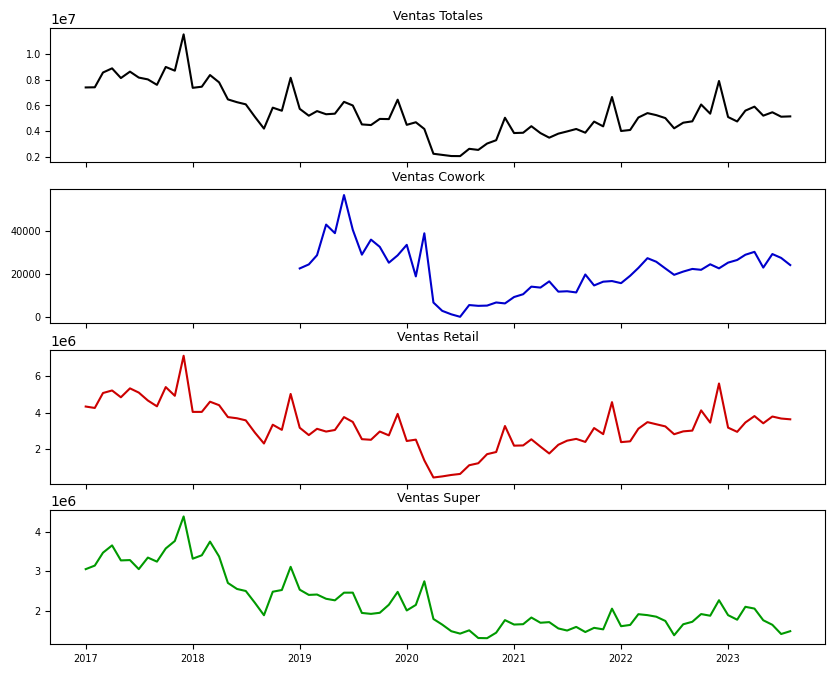

In [21]:
p1, axes = plt.subplots(4,1,figsize=(10,8), sharex=True, sharey=False )
#axes[0].df_vent.ventas_ajustado.plot(figsize=(20,5), title = "Ventas Total", color='black')
#axes[0].df_cowork.ventas_ajustado.plot(figsize=(20,5), title = "Ventas Cowork", color='red')
#axes[0].df_retail.ventas_ajustado.plot(figsize=(20,5), title = "Ventas Retail", color='green')
axes[0].plot(df_vent.ventas_ajustado, color=tema_negro[0])
axes[0].set_title(label = 'Ventas Totales', fontsize=9)
axes[0].tick_params(axis='both', labelsize=7)

axes[1].plot(df_cowork.ventas_ajustado, color=tema_azul[0])
axes[1].set_title(label = 'Ventas Cowork', fontsize=9)
axes[1].tick_params(axis='both', labelsize=7)

axes[2].plot(df_retail.ventas_ajustado, color=tema_rojo[0])
axes[2].set_title(label = 'Ventas Retail', fontsize=9)
axes[2].tick_params(axis='both', labelsize=7)

axes[3].plot(df_super.ventas_ajustado, color=tema_verde[0])
axes[3].set_title(label = 'Ventas Super', fontsize=9)
axes[3].tick_params(axis='both', labelsize=7)



Arranca analisis

Inciso 2 -  Grafico de la serie original

In [22]:
df = df_retail
df['diff1'] = df.ventas_ajustado.diff(periods = 1)
df.diff1[0] = 0
tema = tema_rojo
nombre_serie = 'Ventas Retail'

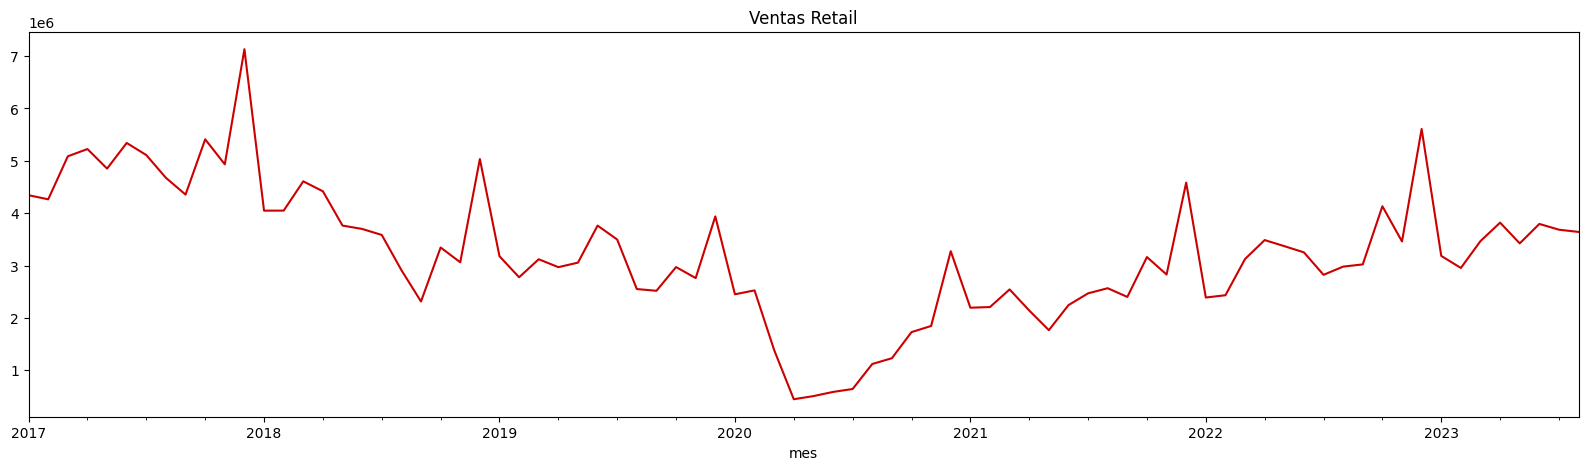

In [23]:
df.ventas_ajustado.plot(figsize=(20,5), title = nombre_serie, color = tema[0])
plt.show()

a simple vista no es estacionaria

Inciso 3 - Funciones de ACF y PACF

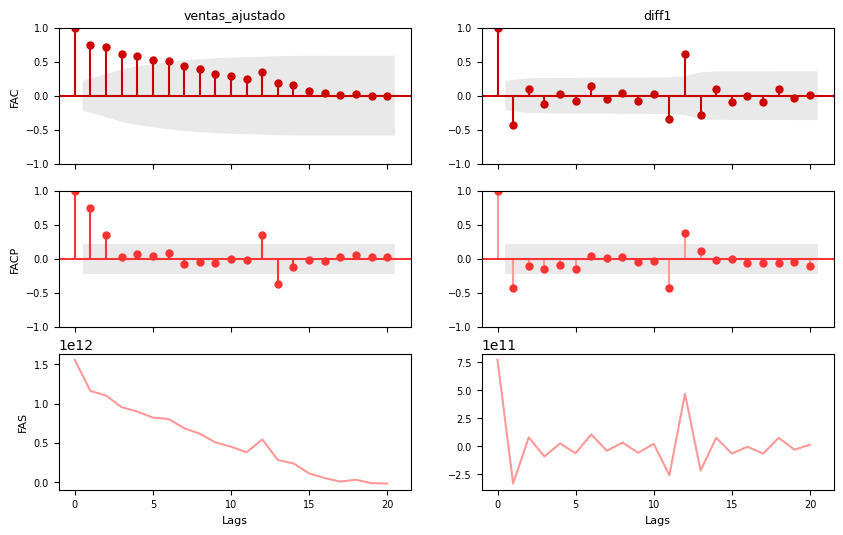

In [24]:
autocov_autocorr(df.ventas_ajustado, df.diff1, 20, tema)

Inciso 4 - Pruebas de raices unitarias

In [25]:
print_test_adf(df.ventas_ajustado)
Phillips_Perron(df.ventas_ajustado)
kpss_test(df.ventas_ajustado)

________________________________________________________________________________________________________________________
Augmented Dickey-Fuller
Estadistico ADF		p-Valor	Estacionaridad	Modo
-2.1134 		0.2391 	No 		Constante sola
-1.5532 		0.8102 	No 		Constante y Tendencia Lineal
-2.7274 		0.4387 	No 		Constante y Tendencia Lineal y Cuadratica
-0.7234 		0.4027 	No 		Sin Contante ni Tendencia
________________________________________________________________________________________________________________________
________________________________________________________________________________________________________________________
Phillips-Perron
Estadistico PP	p-Valor		NumLags		Estacionaridad	nDiffs	Tipo_Regresion
-0.87		0.3400		12		No		1	n-No incluye término independiente ni lineal
-3.62		0.0055		12		Si		1	c-Con término independiente, Sin término lineal
-3.96		0.0100		12		Si		1	ct-Incluye ambos términos
____________________________________________________________________________________

Hasta ahora comprobamos que la serie original no es estacionaria

Pero los tests nos dan indicios de que la primer diferencia podria funcionar

arIma para todos

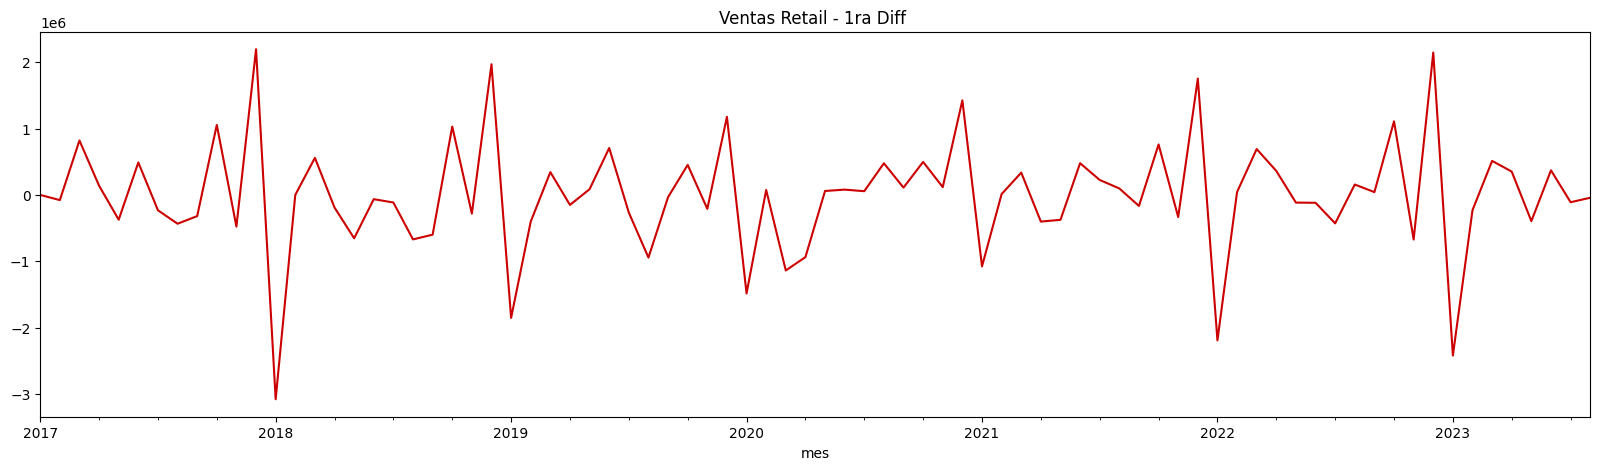

________________________________________________________________________________________________________________________
Augmented Dickey-Fuller
Estadistico ADF		p-Valor	Estacionaridad	Modo
-2.7607 		0.0641 	No 		Constante sola
-4.3799 		0.0024 	Si		Constante y Tendencia Lineal
-4.0866 		0.0245 	Si		Constante y Tendencia Lineal y Cuadratica
-2.6607 		0.0076 	Si		Sin Contante ni Tendencia
________________________________________________________________________________________________________________________
________________________________________________________________________________________________________________________
Phillips-Perron
Estadistico PP	p-Valor		NumLags		Estacionaridad	nDiffs	Tipo_Regresion
-18.04		0.0000		12		Si		0	n-No incluye término independiente ni lineal
-17.99		0.0000		12		Si		0	c-Con término independiente, Sin término lineal
-19.16		0.0000		12		Si		0	ct-Incluye ambos términos
____________________________________________________________________________________

In [26]:
df.diff1.plot(figsize=(20,5), title = f"{nombre_serie} - 1ra Diff ", color = tema[0])
plt.show()
print_test_adf(df.diff1)
Phillips_Perron(df.diff1)
kpss_test(df.diff1)


Inciso 5 - SARIMAX

In [27]:
sarimax = auto_arima(df.ventas_ajustado,
                     start_p=1, max_p=12,
                     start_d=1, max_d=3,
                     start_q=1, max_q=12,
                     start_P=0, max_P=12,
                     start_D=0, max_D=12,
                     start_Q=0, max_Q=12,
           seasonal=True, m=12, trace=True, stepwise=True, information_criterion='aic')
sarimax.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=2383.102, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2391.582, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2376.702, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2378.544, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2389.596, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2380.998, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=2378.115, Time=0.17 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=2377.113, Time=0.22 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2377.577, Time=0.06 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=2379.077, Time=0.48 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=2382.804, Time=0.05 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=2378.722, Time=0.10 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=2378.813, Time=0.14 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=2377.678, Time=0.07 sec
 ARIMA(2,1,1)(1,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   80
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 12)   Log Likelihood               -1184.329
Date:                            Fri, 10 Nov 2023   AIC                           2374.658
Time:                                    20:56:58   BIC                           2381.766
Sample:                                01-01-2017   HQIC                          2377.505
                                     - 08-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2898      0.064     -4.560      0.000      -0.414      -0.165
ar.S.L12       0.2599      0.050      5.210      0.000       0.162       0.358
sigma2      6.422e+11   1.57e-14    4.1e+25      0.000    6.42e+11    6.42e+11
===================================================================================
Ljung-Box (L1) (Q):                   1.12   Jarque-Bera (JB):                71.02
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                            -0.79
Prob(H) (two-sided):                  0.04   Kurtosis:                         7.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

Inciso 6 - Predecir

In [28]:
# Separacion Train/Test
train = df.iloc[:round(len(df)*.80)].ventas_ajustado
test = df.iloc[round(len(df)*.80):].ventas_ajustado

In [29]:
modelo_sarima = SARIMAX(train, order=(1,1,0), seasonal_order=(1,0,0,12))
modelo_sarima = modelo_sarima.fit()
print(modelo_sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                    ventas_ajustado   No. Observations:                   64
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -946.511
Date:                            Fri, 10 Nov 2023   AIC                           1899.022
Time:                                    20:56:58   BIC                           1905.452
Sample:                                01-01-2017   HQIC                          1901.551
                                     - 04-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2737      0.075     -3.627      0.000      -0.422      -0.126
ar.S.L12       0.1545      0.056   

Inciso 7 - Probar otros modelos

In [30]:
modelos_alt = []
modelos_alt.append(SARIMAX(train, order=(1,0,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,0,1), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(1,0,1), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=((1,2),0,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,0,(1,2)), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=((1,2,12),0,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,0,(1,2,12)), seasonal_order=(0,0,0,0)).fit())

modelos_alt.append(SARIMAX(train, order=(1,1,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,1,1), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(1,1,1), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=((1,2),1,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,1,(1,2)), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=((1,2,12),1,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,1,(1,2,12)), seasonal_order=(0,0,0,0)).fit())

modelos_alt.append(SARIMAX(train, order=(1,1,0), seasonal_order=(1,0,0,12)).fit())
modelos_alt.append(SARIMAX(train, order=(1,1,0), seasonal_order=(0,0,1,12)).fit())
modelos_alt.append(SARIMAX(train, order=(1,1,0), seasonal_order=(1,0,1,12)).fit())

modelos_alt.append(SARIMAX(train, order=((1,12),0,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=((1,12),1,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,0,(1,12)), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,1,(1,12)), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,0,0), seasonal_order=(1,0,0,12)).fit())

modelos_alt.append(SARIMAX(train, order=((0,0,0,0,0,0,0,0,0,0,0,1),0,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,0,(0,0,0,0,0,0,0,0,0,0,0,1)), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=((0,0,0,0,0,0,0,0,0,0,0,1),1,0), seasonal_order=(0,0,0,0)).fit())
modelos_alt.append(SARIMAX(train, order=(0,1,(0,0,0,0,0,0,0,0,0,0,0,1)), seasonal_order=(0,0,0,0)).fit())

modelos_alt_nombres = ['AR 1','MA 1','ARMA 1-1','AR 1,2','MA 1,2','AR 1,2,12','MA 1,2,12',
                       'ARIMA 1-1-0','ARIMA 0-1-1','ARIMA 1-1-1','ARIMA 1,2-1-0','ARIMA 0-1-1,2','ARIMA 1,2,12-1-0','ARIMA 0-1-1,2,12',
                       'SARIMA 1-1-0 Season AR 1','SARIMA 1-1-0 Season MA 1','SARIMA 1-1-0 Season ARMA 1-1',
                       'AR 1,12','ARIMA 1,12-1-0',
                       'MA 1,12','ARIMA 0-1-1,12',
                       'ARIMA 0-0-0 Season AR 1',
                       'AR 12','MA 12','ARIMA 12-1-0','ARIMA 0-1-12']

i = 0
for mod in modelos_alt:
    print(f'Modelo {i}-Akaike: {round(mod.aic,4)}-\t{modelos_alt_nombres[i]}')
    i += 1

Modelo 0-Akaike: 1939.3972-	AR 1
Modelo 1-Akaike: 2072.397-	MA 1
Modelo 2-Akaike: 1929.4622-	ARMA 1-1
Modelo 3-Akaike: 1930.729-	AR 1,2
Modelo 4-Akaike: 2057.2077-	MA 1,2
Modelo 5-Akaike: 8.0-	AR 1,2,12
Modelo 6-Akaike: 2028.2274-	MA 1,2,12
Modelo 7-Akaike: 1898.9437-	ARIMA 1-1-0
Modelo 8-Akaike: 1899.373-	ARIMA 0-1-1
Modelo 9-Akaike: 1900.9254-	ARIMA 1-1-1
Modelo 10-Akaike: 1900.967-	ARIMA 1,2-1-0
Modelo 11-Akaike: 1901.1304-	ARIMA 0-1-1,2
Modelo 12-Akaike: 51.0803-	ARIMA 1,2,12-1-0
Modelo 13-Akaike: 1902.9348-	ARIMA 0-1-1,2,12
Modelo 14-Akaike: 1899.0221-	SARIMA 1-1-0 Season AR 1
Modelo 15-Akaike: 1899.1972-	SARIMA 1-1-0 Season MA 1
Modelo 16-Akaike: 1900.5622-	SARIMA 1-1-0 Season ARMA 1-1
Modelo 17-Akaike: 6.0-	AR 1,12
Modelo 18-Akaike: 1938.6846-	ARIMA 1,12-1-0
Modelo 19-Akaike: 2045.4012-	MA 1,12
Modelo 20-Akaike: 1900.9043-	ARIMA 0-1-1,12
Modelo 21-Akaike: 2025.9619-	ARIMA 0-0-0 Season AR 1
Modelo 22-Akaike: 2025.9619-	AR 12
Modelo 23-Akaike: 2078.8583-	MA 12
Modelo 24-Akaike: 19

In [31]:
modelo_pick = modelos_alt[25]
print(modelo_pick.summary())


                                SARIMAX Results                                
Dep. Variable:         ventas_ajustado   No. Observations:                   64
Model:             SARIMAX(0, 1, [12])   Log Likelihood                -950.372
Date:                 Fri, 10 Nov 2023   AIC                           1904.744
Time:                         20:57:06   BIC                           1909.030
Sample:                     01-01-2017   HQIC                          1906.429
                          - 04-01-2022                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L12         0.2075      0.038      5.518      0.000       0.134       0.281
sigma2      6.077e+11    2.4e-14   2.54e+25      0.000    6.08e+11    6.08e+11
Ljung-Box (L1) (Q):                   9.31  

Dados los resultados finales de los tests, principalmente el AIC porque es facil de evaluar a simple vista

Concluimos que el mejor modelo es el que propuso AutoARIMA (Un ARIMA 1-1-0 con Season AR 1 (12))

Inciso 8 - Analisis de Diagnostico

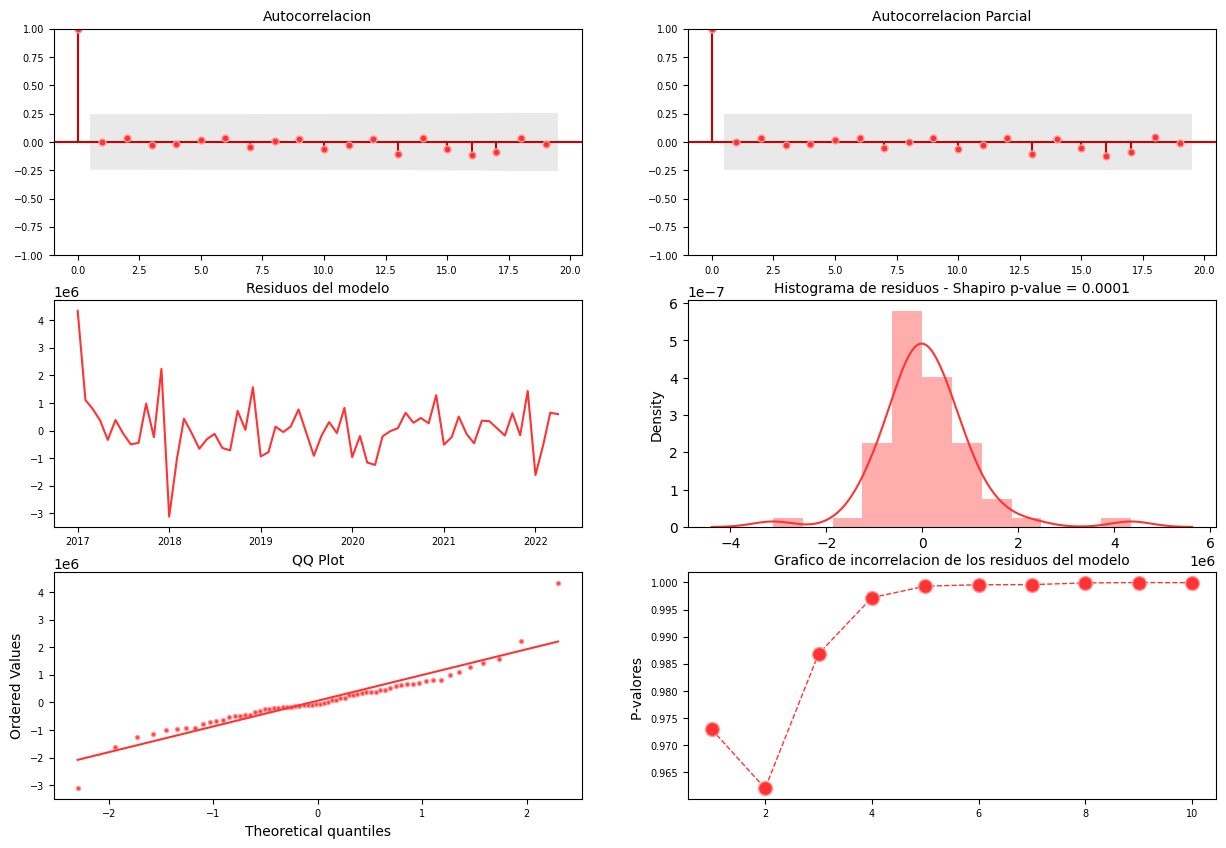

In [32]:
prueba_residuos(modelo_sarima.resid, color = tema)

La hipotesis nula es que los datos son independientes
vemos que generalmente no rechazan

aprueba el test

notamos que los residuos son ruido blanco, lo cual es favorable

pero que su distribucion no es normal, lo que reduce la validez del modelo para efectuar predicciones

Inciso 9 - Pronosticar

In [33]:
predicciones_sarima = modelo_sarima.get_forecast(16)

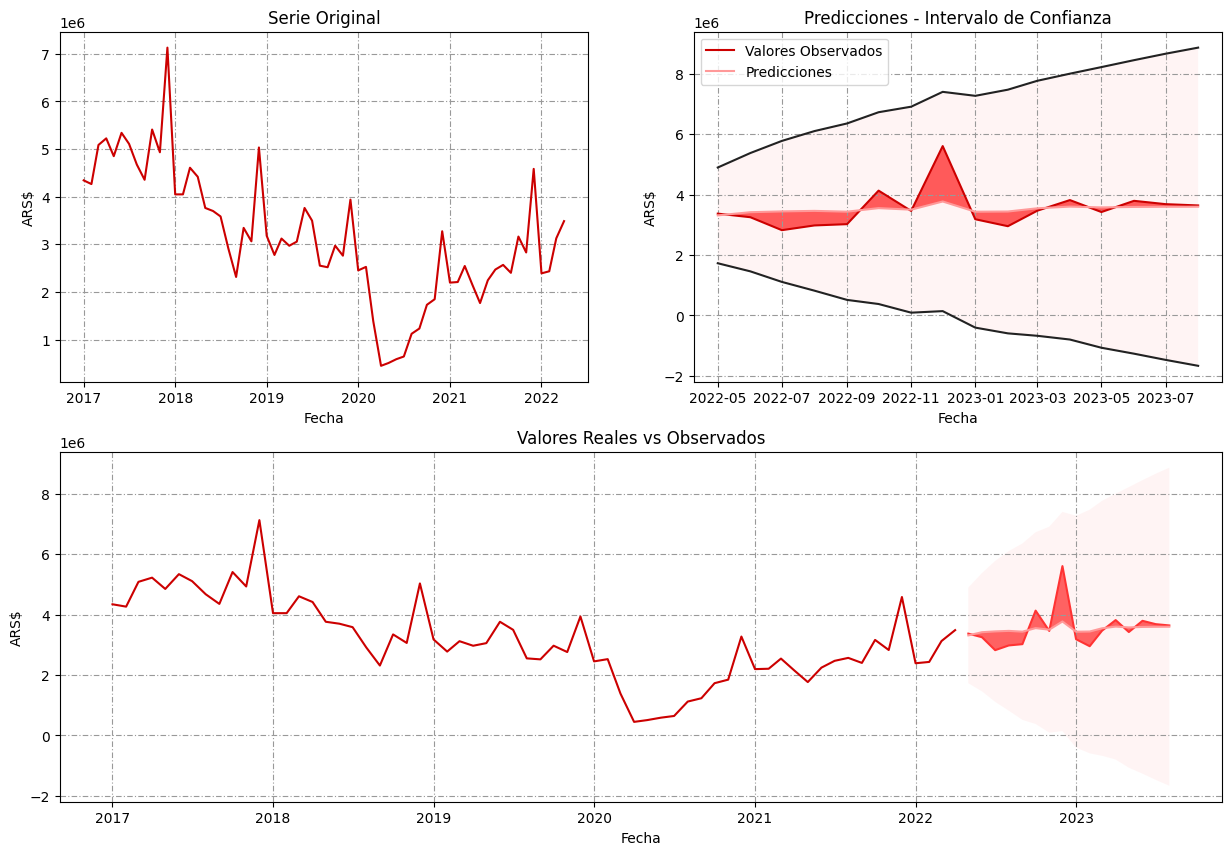

In [34]:
graficar_pred(train, test[:16], predicciones_sarima.predicted_mean, predicciones_sarima.conf_int(), color = tema)

In [35]:
evaluar_metricas(test[:16], predicciones_sarima.predicted_mean )

MSE:	309256970025
MAE:	357021
RMSE:	556109
MAPE:	0.095


Inciso 10 - VAR

In [36]:
serieVAR = pd.concat([df_retail.ventas_ajustado, df_super.ventas_ajustado], axis=1)
serieVAR.columns = ['retail','super']
#serieVAR.dropna(inplace=True)
serieVAR.head()


,retail,super
mes,,
2017-01-01,4.343371e+06,3.058102e+06
2017-02-01,4.265286e+06,3.147924e+06
2017-03-01,5.086280e+06,3.475063e+06
2017-04-01,5.224931e+06,3.659147e+06
2017-05-01,4.851358e+06,3.279091e+06


In [37]:
split = .8
train2 = serieVAR.iloc[:round(len(serieVAR)*split)]
test2 = serieVAR.iloc[round(len(serieVAR)*split):]

In [38]:
grangers_causation_matrix(train2, variables = train2.columns, maxlag=5, verbose=True)

Y = retail, X = retail, P Values = [(0.999999879603763, 1), (0.9999999999999937, 2), (1.0, 3), (1.0, 4), (1.0, 5)]
Y = super, X = retail, P Values = [(0.7693181498061139, 1), (0.19725024547050712, 2), (0.11128664390652253, 3), (0.12924571642017074, 4), (0.11854555633551117, 5)]
Y = retail, X = super, P Values = [(0.39998047957882277, 1), (0.8888560668826064, 2), (0.8656479167214611, 3), (0.7812741772564546, 4), (0.7927581675675324, 5)]
Y = super, X = super, P Values = [(0.999999922872396, 1), (1.0, 2), (1.0, 3), (1.0, 4), (1.0, 5)]


,retail_x,super_x
retail_y,1.000000,0.39998
super_y,0.111287,1.00000


En base a los resultados del test de granger, vemos que no se rechaza la hipotesis nula

es decir que no podemos afirmar que haya una relacion de causalidad entre las variables elegidas

Esto quiere decir que nuestros datos no son un buen candidato para el modelo VAR

Inciso 11 - Impulso-Respuesta

No aplica

Inciso 12 - 